In [17]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt


# Importing and cleaning reddit comments

In [10]:
reddit_comments = pd.read_csv("Datasets/reddit_comments.csv")
reddit_comments.head(10)

/var/folders/bz/qyvd1hfs07v7gkh9fbvpy51m0000gn/T/ipykernel_72824/262127796.py:1: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_comments = pd.read_csv("Datasets/reddit_comments.csv")


,body,post_date,upvotes,parent_id,top_level_id,post_title,post_id
0,"Damn, even Scorsese pirated Yeezus.",1.371479e+09,697.0,NaN,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9
1,[Leo loves it though] (http://i.imgur.com/cPTI...,1.371495e+09,168.0,cakjh4s,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9
2,[Not as much as Ethan Suplee](http://i.imgur.c...,1.371497e+09,71.0,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9
3,"Please put ""white people"" over this.",1.371499e+09,25.0,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9
4,[close up of dat face](http://i.imgur.com/bcWb...,1.371497e+09,3.0,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9
5,I can watch this allll day.,1.371506e+09,3.0,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9
6,Is that Ethan Suplee in the background?\n\nEDI...,1.371496e+09,2.0,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9
7,[awwww yeah it is](http://i.imgur.com/xNcCDsR....,1.371497e+09,2.0,cakpphx,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9
8,"Just watched the trailer, went to this thread ...",1.371508e+09,2.0,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9
9,Is that Jon Bernthal in the background?,1.371518e+09,2.0,cakpae0,cakjh4s,Scorsese's 'The Wolf Of Wall Street' Trailer D...,1ghzr9


In [11]:
reddit_comments['post_date'] = pd.to_datetime(reddit_comments['post_date'], unit='s')
reddit_comments['post_date'].head()

0   2013-06-17 14:27:18
1   2013-06-17 18:53:59
2   2013-06-17 19:16:00
3   2013-06-17 19:56:29
4   2013-06-17 19:16:55
Name: post_date, dtype: datetime64[ns]

In [12]:
missing_values = reddit_comments.isnull().sum()
print(missing_values)

body                16
post_date       762486
upvotes         762486
parent_id       884572
top_level_id    762486
post_title      762486
post_id         762486
dtype: int64


In [13]:
reddit_comments.dropna(subset=['post_date'], inplace=True)
reddit_comments.dropna(subset=['body'], inplace=True)
missing_values = reddit_comments.isnull().sum()
print(missing_values)

body                 0
post_date            0
upvotes              0
parent_id       122082
top_level_id         0
post_title           0
post_id              0
dtype: int64


In [14]:
reddit_comments['upvotes'] = reddit_comments['upvotes'].astype(int)

In [15]:
reddit_comments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 451017 entries, 0 to 1213518
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   body          451017 non-null  object        
 1   post_date     451017 non-null  datetime64[ns]
 2   upvotes       451017 non-null  int64         
 3   parent_id     328935 non-null  object        
 4   top_level_id  451017 non-null  object        
 5   post_title    451017 non-null  object        
 6   post_id       451017 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 27.5+ MB


In [19]:
reddit_comments.describe([0.01,0.1,0.25,0.5,0.75,0.9,0.99])

,post_date,upvotes
count,451017,451017.000000
mean,2018-10-10 05:29:28.340971520,66.718920
min,2009-07-01 01:23:00,-286.000000
1%,2012-11-09 02:46:50.760000,-8.000000
10%,2014-07-26 13:35:23,1.000000
25%,2016-05-04 13:58:11,2.000000
50%,2018-09-13 17:21:33,6.000000
75%,2021-06-23 00:54:05,23.000000
90%,2023-02-10 15:48:31,99.000000
99%,2024-01-25 17:49:06.360000,1164.000000


/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


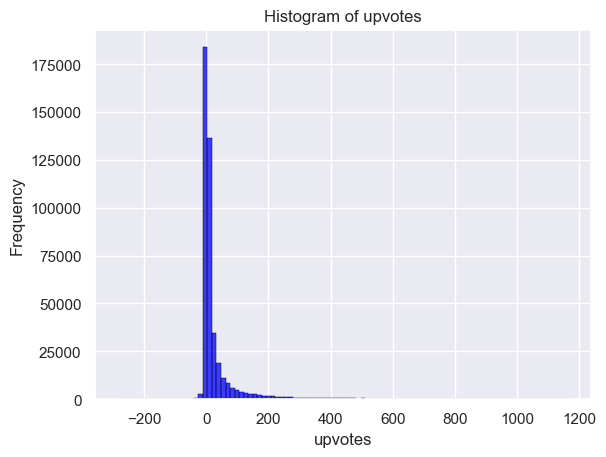

In [20]:
sns.set()
#removing top 1% for better viz
sns.histplot(reddit_comments[reddit_comments['upvotes']<=1164]['upvotes'], kde=False, bins=100, color='blue', edgecolor='black')
plt.title('Histogram of upvotes')
plt.xlabel('upvotes')
plt.ylabel('Frequency')
plt.show()

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


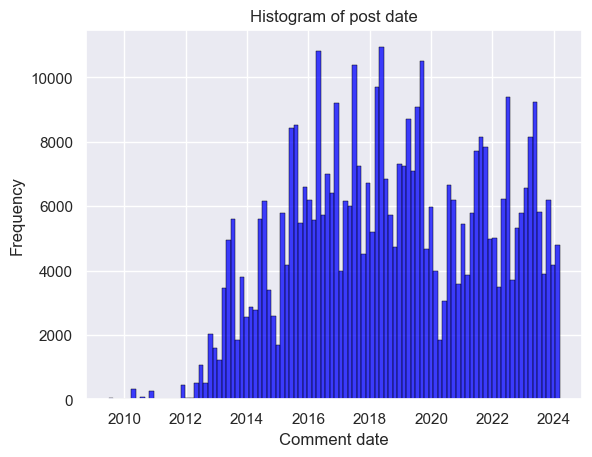

In [21]:
sns.set()
#removing top 1% for better viz
sns.histplot(reddit_comments['post_date'], kde=False, bins=100, color='blue', edgecolor='black')
plt.title('Histogram of post date')
plt.xlabel('Comment date')
plt.ylabel('Frequency')
plt.show()

# Movie title - reddit post mapped dataset

In [23]:
movie_post_df = pd.read_excel("Datasets/matched_titles_post_id.xlsx")
movie_post_df.head(10)

,post_id,post_title,post_url,post_text,post_score,num_comments,post_create_date,post_flair,movie_searched,Match,domestic opening
0,1ghzr9,Scorsese's 'The Wolf Of Wall Street' Trailer D...,http://youtu.be/iszwuX1AK6A,NaN,2741,948,1371448361,NaN,The Wolf of Wall Street,1,18361578
1,19pqs5,Iron Man 3 theatrical trailer!,http://screen.yahoo.com/iron-man-3-theatrical-...,NaN,1606,643,1362502700,NaN,Iron Man 3,1,174144585
2,1e1bf7,Gravity - Official Trailer,http://www.youtube.com/watch?v=ufsrgE0BYf0,NaN,2718,1841,1368144036,NaN,Gravity,1,55785112
3,12vwfz,World War Z - Official Trailer (HD),http://www.youtube.com/watch?v=HcwTxRuq-uk&fea...,NaN,2238,3327,1352419779,NaN,World War Z,1,66411834
4,1fsrka,New Nokia Man of Steel Trailer,http://www.youtube.com/watch?feature=player_em...,NaN,1915,829,1370536093,NaN,Man of Steel,1,116619362
5,1jwcr4,"""HER"" trailer. New movie from Spike Jones star...",http://www.youtube.com/watch?v=6QRvTv_tpw0,NaN,3099,1576,1375898978,NaN,Her,1,260382
6,1g4q62,The Hobbit: The Desolation of Smaug Trailer,http://www.youtube.com/watch?v=dUlxoZRwUS0&fea...,NaN,2813,1755,1370969415,NaN,The Hobbit: The Desolation of Smaug,1,73645197
7,u03ia,"New trailer for ""The Great Gatsby""",http://www.youtube.com/watch?v=rARN6agiW7o&fea...,NaN,697,451,1337729885,NaN,The Great Gatsby,1,50085185
8,1fh6qa,"Prisoners TRAILER 1 (2013) - Hugh Jackman, Jak...",http://www.youtube.com/watch?feature=player_em...,NaN,286,95,1370113632,NaN,Prisoners,1,20817053
9,1lyg0e,12 Years a Slave - [Trailer],http://www.youtube.com/watch?v=NIqodUJ-UfM,NaN,1617,260,1378616665,NaN,12 Years a Slave,1,923715


In [24]:
movie_post_df['post_create_date'] = pd.to_datetime(movie_post_df['post_create_date'], unit='s')
movie_post_df['post_create_date'].head()

0   2013-06-17 05:52:41
1   2013-03-05 16:58:20
2   2013-05-10 00:00:36
3   2012-11-09 00:09:39
4   2013-06-06 16:28:13
Name: post_create_date, dtype: datetime64[ns]

In [25]:
missing_values = movie_post_df.isnull().sum()
print(missing_values)

post_id                0
post_title             0
post_url               0
post_text           1393
post_score             0
num_comments           0
post_create_date       0
post_flair           542
movie_searched         0
Match                  0
domestic opening       0
dtype: int64


In [26]:
movie_post_df.drop(['post_text'], axis=1,inplace=True)

In [27]:
movie_post_df.describe([0.01,0.1,0.25,0.5,0.75,0.9,0.99])

,post_score,num_comments,post_create_date,Match,domestic opening
count,1398.000000,1398.000000,1398,1398.0,1.398000e+03
mean,3982.643062,648.209585,2018-01-05 05:58:38.703147264,1.0,1.503010e+07
min,0.000000,0.000000,2011-01-20 07:12:28,1.0,4.700000e+01
1%,0.000000,0.000000,2012-11-21 16:16:13.660000,1.0,1.429940e+03
10%,2.000000,1.000000,2013-12-11 06:07:11.800000,1.0,9.792400e+03
25%,30.000000,13.250000,2015-07-21 19:53:13,1.0,5.373375e+04
50%,283.500000,108.000000,2017-09-12 16:06:29,1.0,1.710844e+06
75%,1945.000000,511.000000,2020-07-30 00:05:41,1.0,1.602418e+07
90%,13270.000000,1957.100000,2022-09-28 22:30:45.900000,1.0,4.169905e+07
99%,51093.440000,6815.580000,2023-09-14 19:31:18.540000,1.0,1.621416e+08


/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


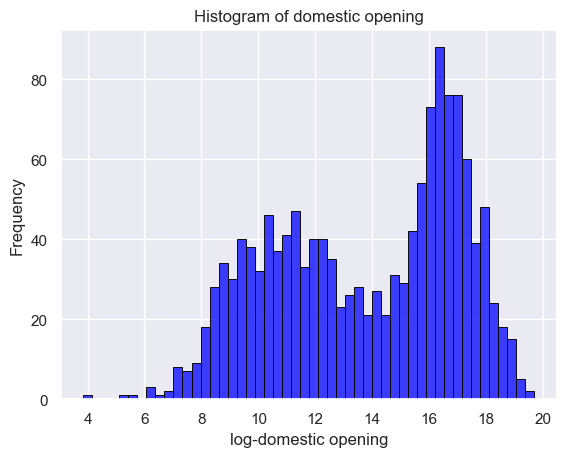

In [30]:
sns.set()
#removing top 1% for better viz
sns.histplot(np.log(movie_post_df['domestic opening']), kde=False, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of domestic opening')
plt.xlabel('log-domestic opening')
plt.ylabel('Frequency')
plt.show()

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


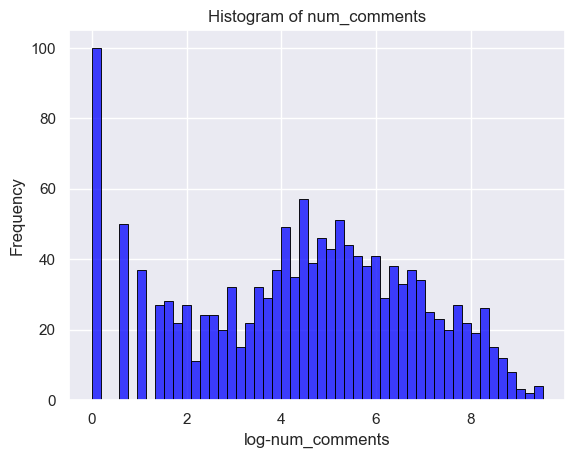

In [31]:
sns.set()
#removing top 1% for better viz
sns.histplot(np.log(movie_post_df['num_comments']+1), kde=False, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of num_comments')
plt.xlabel('log-num_comments')
plt.ylabel('Frequency')
plt.show()

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


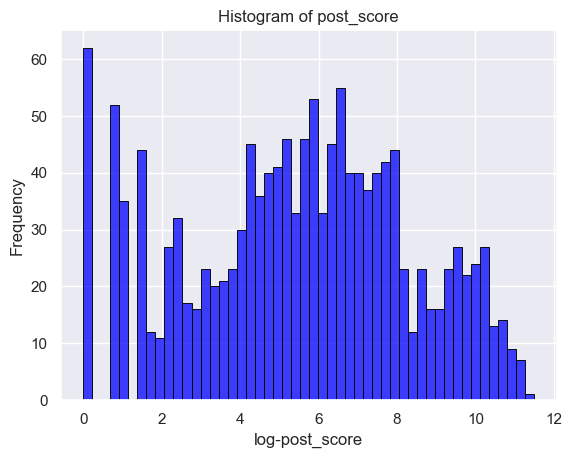

In [32]:
sns.set()

sns.histplot(np.log(movie_post_df['post_score']+1), kde=False, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of post_score')
plt.xlabel('log-post_score')
plt.ylabel('Frequency')
plt.show()

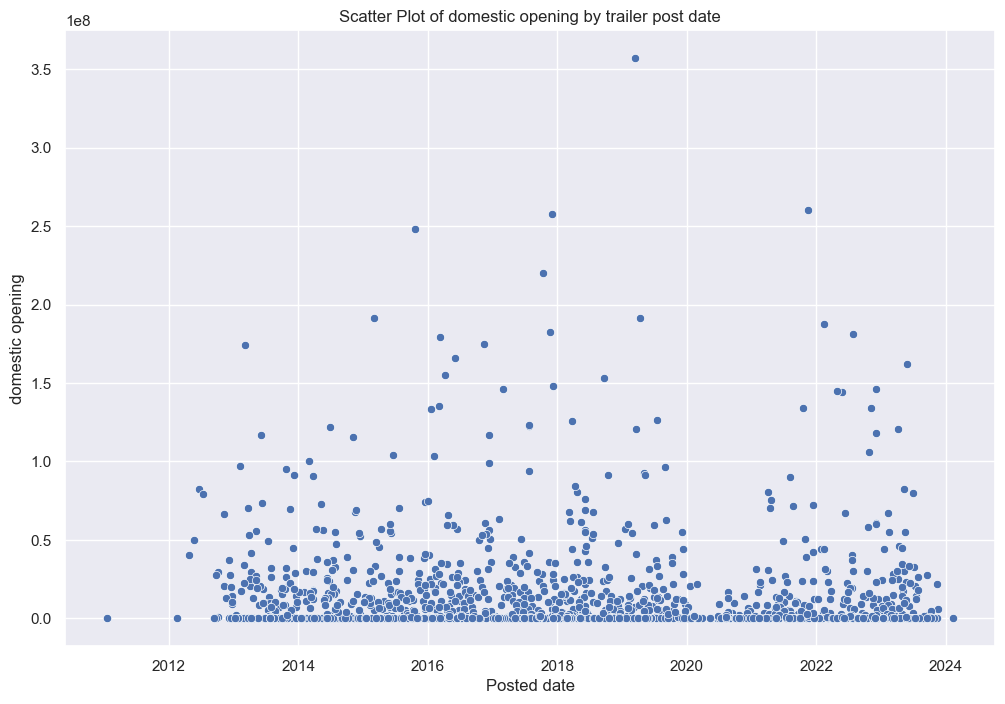

In [33]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='post_create_date', y='domestic opening', data=movie_post_df)

# Set labels and title
plt.xlabel('Posted date')
plt.ylabel('domestic opening')
plt.title('Scatter Plot of domestic opening by trailer post date')

# Show the plot
plt.show()

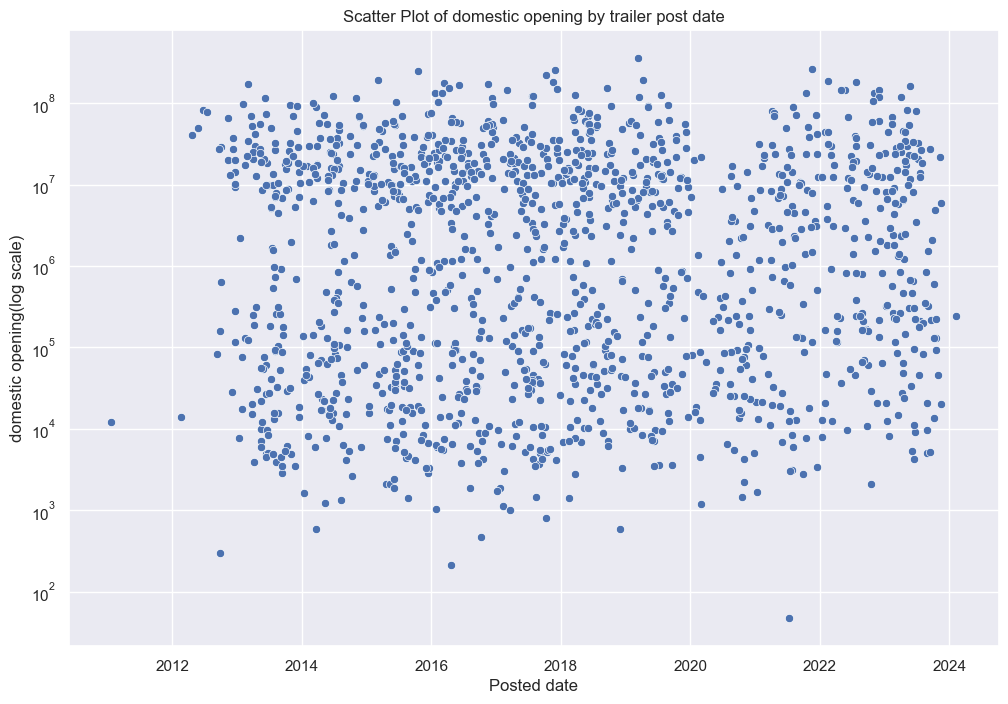

In [34]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='post_create_date', y='domestic opening', data=movie_post_df)

plt.yscale('log')
# Set labels and title
plt.xlabel('Posted date')
plt.ylabel('domestic opening(log scale)')
plt.title('Scatter Plot of domestic opening by trailer post date')

# Show the plot
plt.show()

In [93]:
merged_df1['movie_searched'].nunique()

1389

# Importing and merging Movie Metadata from different sources

In [35]:
movie_list = pd.read_csv("Datasets/movie_list.csv")
movie_list.head(10)

,title,release_date,genre_ids,vote_average,vote_count,popularity,id
0,The Wolf of Wall Street,2013-12-25,"[80, 18, 35]",8.035,22986,97.456,106646
1,Iron Man 3,2013-05-03,"[28, 12, 878]",6.928,21503,66.964,68721
2,The Hunger Games: Catching Fire,2013-11-22,"[12, 28, 878]",7.427,16740,56.579,101299
3,Thor: The Dark World,2013-11-08,"[28, 12, 14]",6.500,16730,61.215,76338
4,Frozen,2013-11-27,"[16, 10751, 12, 14]",7.247,15931,98.957,109445
5,Now You See Me,2013-05-31,"[53, 80]",7.344,15024,59.912,75656
6,Gravity,2013-10-04,"[878, 53, 18]",7.164,14780,30.547,49047
7,World War Z,2013-06-21,"[28, 18, 27, 878, 53]",6.811,14775,75.313,72190
8,Man of Steel,2013-06-14,"[28, 12, 878]",6.621,14637,52.363,49521
9,Her,2013-12-18,"[10749, 878, 18]",7.859,13741,29.731,152601


In [52]:
movie_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14661 entries, 0 to 14660
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            14661 non-null  object        
 1   release_date     14661 non-null  datetime64[ns]
 2   genre_ids        14661 non-null  object        
 3   vote_average     14661 non-null  float64       
 4   vote_count       14661 non-null  int64         
 5   popularity       14661 non-null  float64       
 6   id               14661 non-null  int64         
 7   Action           14661 non-null  int64         
 8   Adventure        14661 non-null  int64         
 9   Animation        14661 non-null  int64         
 10  Comedy           14661 non-null  int64         
 11  Crime            14661 non-null  int64         
 12  Documentary      14661 non-null  int64         
 13  Drama            14661 non-null  int64         
 14  Family           14661 non-null  int64

In [36]:
missing_values = movie_list.isnull().sum()
print(missing_values)

title           0
release_date    0
genre_ids       0
vote_average    0
vote_count      0
popularity      0
id              0
dtype: int64


In [51]:
movie_list['release_date'] = pd.to_datetime(movie_list['release_date'])

In [43]:
import ast
movie_list['genre_ids'] = movie_list['genre_ids'].apply(ast.literal_eval)
movie_list['genre_ids'].head()

0           [80, 18, 35]
1          [28, 12, 878]
2          [12, 28, 878]
3           [28, 12, 14]
4    [16, 10751, 12, 14]
Name: genre_ids, dtype: object

In [44]:

exploded_df = movie_list['genre_ids'].explode()
exploded_df.head()
frequency = exploded_df.value_counts()
frequency_dict = frequency.to_dict()
pprint(frequency_dict)

0    80
0    18
0    35
1    28
1    12
Name: genre_ids, dtype: object

In [45]:
from collections import defaultdict
from pprint import pprint
genre_freq = defaultdict(int)

for i,r in movie_list.iterrows():
    
    for g in r['genre_ids']:
        genre_freq[g]+=1


pprint(genre_freq)        
    
    

defaultdict(<class 'int'>,
            {12: 992,
             14: 818,
             16: 869,
             18: 4758,
             27: 2736,
             28: 1816,
             35: 3848,
             36: 387,
             37: 127,
             53: 3259,
             80: 1181,
             99: 2214,
             878: 1285,
             9648: 1054,
             10402: 667,
             10749: 2077,
             10751: 1161,
             10752: 209,
             10770: 2026})


In [46]:
genre_dict = {
    28: "Action",
    12: "Adventure",
    16: "Animation",
    35: "Comedy",
    80: "Crime",
    99: "Documentary",
    18: "Drama",
    10751: "Family",
    14: "Fantasy",
    36: "History",
    27: "Horror",
    10402: "Music",
    9648: "Mystery",
    10749: "Romance",
    878: "Science Fiction",
    10770: "TV Movie",
    53: "Thriller",
    10752: "War",
    10750: "Western"
}

In [49]:
for genre_id, genre_name in genre_dict.items():
    
    movie_list[genre_name] = movie_list['genre_ids'].apply(lambda ids: 1 if genre_id in ids else 0)

In [53]:
movie_list.head()

,title,release_date,genre_ids,vote_average,vote_count,popularity,id,Action,Adventure,Animation,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,The Wolf of Wall Street,2013-12-25,"[80, 18, 35]",8.035,22986,97.456,106646,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Iron Man 3,2013-05-03,"[28, 12, 878]",6.928,21503,66.964,68721,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,The Hunger Games: Catching Fire,2013-11-22,"[12, 28, 878]",7.427,16740,56.579,101299,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3,Thor: The Dark World,2013-11-08,"[28, 12, 14]",6.500,16730,61.215,76338,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Frozen,2013-11-27,"[16, 10751, 12, 14]",7.247,15931,98.957,109445,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [54]:
movie_list.drop(['genre_ids','vote_average','vote_count','popularity','id'], axis=1,inplace=True)
movie_list.head(2)

,title,release_date,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,The Wolf of Wall Street,2013-12-25,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Iron Man 3,2013-05-03,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [96]:
unique_combos_df = movie_list[['title', 'release_date']].drop_duplicates()

# If you just need the count of unique combinations, you can use:
unique_combos_count = unique_combos_df.shape[0]
unique_combos_count

14661

# importing runtime, budget, production data

In [73]:
movie_details = pd.read_csv("Datasets/movie_details.csv")
movie_details.head(5)

,title,runtime,budget,imdb_id,revenue,produced_by
0,The Wolf of Wall Street,180,100000000,tt0993846,392000000,Red Granite Pictures
1,Iron Man 3,130,200000000,tt1300854,1215577205,Marvel Studios
2,The Hunger Games: Catching Fire,146,130000000,tt1951264,865011746,Lionsgate
3,Thor: The Dark World,112,170000000,tt1981115,644783140,Marvel Studios
4,Frozen,102,150000000,tt2294629,1274219009,Walt Disney Pictures


In [74]:
movie_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14661 entries, 0 to 14660
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        14661 non-null  object
 1   runtime      14661 non-null  int64 
 2   budget       14661 non-null  int64 
 3   imdb_id      14589 non-null  object
 4   revenue      14661 non-null  int64 
 5   produced_by  14661 non-null  object
dtypes: int64(3), object(3)
memory usage: 687.4+ KB


In [75]:
produced_by_counts = movie_details[movie_details['runtime']>=60]['produced_by'].value_counts()
is_big_production = (produced_by_counts > 10).to_dict()
is_big_production['unknown'] = False
#pprint(is_big_production)
movie_details['big_production'] = movie_details['produced_by'].map(is_big_production)
movie_details['big_production'].fillna(False, inplace=True)
movie_details.head()

/var/folders/bz/qyvd1hfs07v7gkh9fbvpy51m0000gn/T/ipykernel_72824/9567294.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movie_details['big_production'].fillna(False, inplace=True)
/var/folders/bz/qyvd1hfs07v7gkh9fbvpy51m0000gn/T/ipykernel_72824/9567294.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mo

,title,runtime,budget,imdb_id,revenue,produced_by,big_production
0,The Wolf of Wall Street,180,100000000,tt0993846,392000000,Red Granite Pictures,False
1,Iron Man 3,130,200000000,tt1300854,1215577205,Marvel Studios,True
2,The Hunger Games: Catching Fire,146,130000000,tt1951264,865011746,Lionsgate,True
3,Thor: The Dark World,112,170000000,tt1981115,644783140,Marvel Studios,True
4,Frozen,102,150000000,tt2294629,1274219009,Walt Disney Pictures,True


In [77]:
big_production_percent = movie_details['big_production'].value_counts(normalize=True) * 100

# Display the percentages
print(big_production_percent)

big_production
False    66.741696
True     33.258304
Name: proportion, dtype: float64


/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


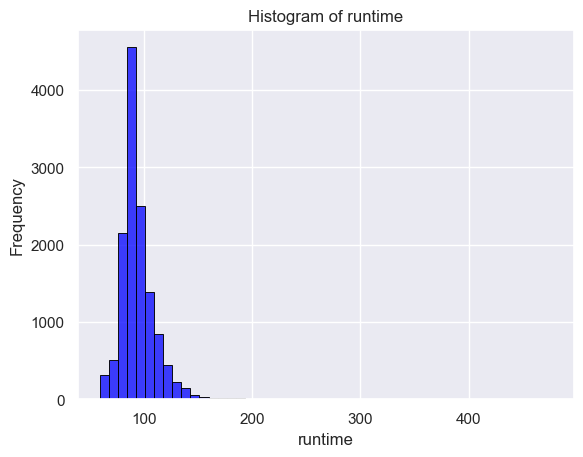

In [62]:
sns.set()
#removing top 1% for better viz
sns.histplot(movie_details[movie_details['runtime']>=60]['runtime'], kde=False, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of runtime')
plt.xlabel('runtime')
plt.ylabel('Frequency')
plt.show()

In [61]:
movie_details[movie_details['runtime']<60].sample(5) #need yo remove <60 run time?

,title,runtime,budget,imdb_id,revenue,produced_by
2707,I Heard It Too,8,0,tt5336576,0,Unknown
1159,The Walking Dead: A Decade of Dead,22,0,tt3353148,0,Unknown
1208,The Captain,6,0,tt2508572,0,Blue-Tongue Films
8118,Teddy Pendergrass: If You Don't Know Me,0,0,tt6522666,0,Unknown
3685,Journey to Space,42,0,tt4292554,0,K2 Films


In [80]:
movie_details.describe([0.01,0.1,0.25,0.5,0.75,0.9,0.99])

,runtime,budget,revenue
count,14661.000000,1.466100e+04,1.466100e+04
mean,88.076257,5.818286e+06,1.625224e+07
std,27.589535,2.502501e+07,9.912933e+07
min,0.000000,0.000000e+00,0.000000e+00
1%,3.000000,0.000000e+00,0.000000e+00
10%,60.000000,0.000000e+00,0.000000e+00
25%,84.000000,0.000000e+00,0.000000e+00
50%,90.000000,0.000000e+00,0.000000e+00
75%,100.000000,0.000000e+00,0.000000e+00
90%,112.000000,9.000000e+06,4.100000e+06


/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


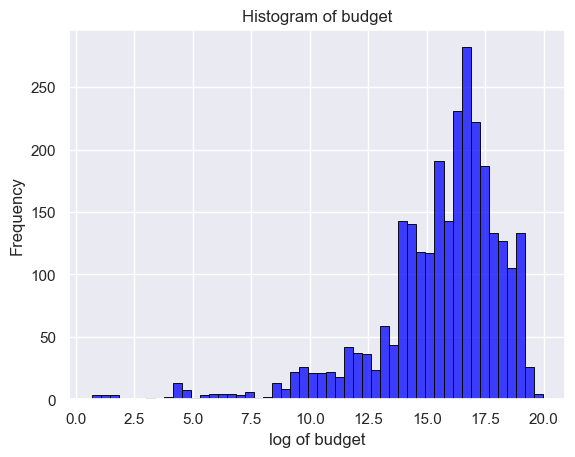

In [83]:
sns.set()
#removing top 1% for better viz
sns.histplot(np.log(movie_details[movie_details['budget']>0]['budget']+1), kde=False, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of budget')
plt.xlabel('log of budget')
plt.ylabel('Frequency')
plt.show()

In [86]:
movie_details[movie_details['budget']>0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2753 entries, 0 to 14658
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           2753 non-null   object
 1   runtime         2753 non-null   int64 
 2   budget          2753 non-null   int64 
 3   imdb_id         2748 non-null   object
 4   revenue         2753 non-null   int64 
 5   produced_by     2753 non-null   object
 6   big_production  2753 non-null   bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 153.2+ KB


In [ ]:
#movie_details.drop([],axis=1,inplace=True)

# Movie performance - revenue vs BO

In [84]:
movie_performance = pd.read_csv("Datasets/movie_performance.csv")
movie_performance.head(5)

,movie_id,movie_name,domestic_opening,budget,gross_domestic,gross_international,gross_worldwide
0,tt0993846,The Wolf of Wall Street,18361578.0,100000000.0,116900694.0,289977539.0,4.068782e+08
1,tt1300854,Iron Man 3,174144585.0,200000000.0,409013994.0,806563211.0,1.215577e+09
2,tt2294629,Frozen,243390.0,150000000.0,400953009.0,996089521.0,1.397043e+09
3,tt1670345,Now You See Me,29350389.0,75000000.0,117723989.0,234000000.0,3.517240e+08
4,tt1454468,Gravity,55785112.0,100000000.0,274092705.0,498938878.0,7.730316e+08


In [85]:
movie_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4223 entries, 0 to 4222
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   movie_id             4217 non-null   object 
 1   movie_name           4223 non-null   object 
 2   domestic_opening     1745 non-null   float64
 3   budget               582 non-null    float64
 4   gross_domestic       1826 non-null   float64
 5   gross_international  2249 non-null   float64
 6   gross_worldwide      2511 non-null   float64
dtypes: float64(5), object(2)
memory usage: 231.1+ KB


# OMDB data - getting movie rating

In [113]:
omdb_details = pd.read_csv("Datasets/omdb_details.csv")
omdb_details.head(5)

,Title,Actors,Awards,Rated,imdbRating,imdbVotes,Metascore,BoxOffice
0,The Wolf of Wall Street,"Leonardo DiCaprio, Jonah Hill, Margot Robbie",Nominated for 5 Oscars. 37 wins & 179 nominati...,R,8.2,"1,557,215",75.0,"$116,900,694"
1,Iron Man 3,"Robert Downey Jr., Guy Pearce, Gwyneth Paltrow",Nominated for 1 Oscar. 20 wins & 63 nomination...,PG-13,7.1,"894,824",62.0,"$409,013,994"
2,The Hunger Games: Catching Fire,"Jennifer Lawrence, Josh Hutcherson, Liam Hemsw...",22 wins & 68 nominations,PG-13,7.5,"714,737",76.0,"$424,668,047"
3,Thor: The Dark World,"Chris Hemsworth, Natalie Portman, Tom Hiddleston",4 wins & 21 nominations,PG-13,6.8,"719,979",54.0,"$206,362,140"
4,Frozen,"Kristen Bell, Idina Menzel, Jonathan Groff",Won 2 Oscars. 83 wins & 60 nominations total,PG,7.4,"660,476",75.0,"$400,953,009"


In [114]:
omdb_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14661 entries, 0 to 14660
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       14573 non-null  object 
 1   Actors      14395 non-null  object 
 2   Awards      7774 non-null   object 
 3   Rated       11211 non-null  object 
 4   imdbRating  14421 non-null  float64
 5   imdbVotes   14534 non-null  object 
 6   Metascore   5147 non-null   float64
 7   BoxOffice   3293 non-null   object 
dtypes: float64(2), object(6)
memory usage: 916.4+ KB


In [115]:
omdb_details['Rated'].value_counts()

Rated
R            2719
Not Rated    2424
PG-13        1269
TV-MA        1042
TV-14         979
TV-G          852
PG            659
TV-PG         548
Unrated       430
G             139
TV-Y7          60
TV-Y           41
16+            14
TV-Y7-FV        9
18+             6
Approved        4
NC-17           4
13+             2
M               1
X               1
T               1
AO              1
TV-13           1
M/PG            1
E               1
18              1
12              1
E10+            1
Name: count, dtype: int64

# Merging the datasets

In [88]:
merged_df1 = movie_post_df.merge(movie_list, left_on='movie_searched', right_on='title')
merged_df1.sample()
# Second merge adding df3
#final_merged_df = merged_df.merge(df3, left_on='key2', right_on='key3')


,post_id,post_title,post_url,post_score,num_comments,post_create_date,post_flair,movie_searched,Match,domestic opening,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
1051,iq2u2o,FREAKY - Official Trailer (HD),https://www.youtube.com/watch?v=EqPnIcDW9g0&fe...,632,194,2020-09-10 13:01:28,Trailers,Freaky,1,3600355,...,0,1,0,0,0,0,0,1,0,0


## Duplicates due to movies with same titles

In [98]:
merged_df1['date_diff'] = merged_df1['release_date'] - merged_df1['post_create_date']

merged_df1['date_diff'].describe([0.01,0.1,0.25,0.5,0.75,0.9,0.99])
#check for movies with same names but different periods

count                           1410
mean      75 days 11:26:05.125531915
std      332 days 20:45:21.134157044
min             -3071 days +06:54:21
1%       -1336 days +08:11:54.740000
10%           2 days 23:53:08.100000
25%          37 days 16:05:28.250000
50%                 78 days 10:37:32
75%                130 days 21:32:08
90%      206 days 11:53:25.100000024
99%      881 days 11:02:48.590000704
max               2989 days 16:47:32
Name: date_diff, dtype: object

In [100]:
duplicates = merged_df1[merged_df1.duplicated(subset=['movie_searched'], keep=False)][['post_title','post_create_date','movie_searched','release_date','date_diff']]
duplicates

,post_title,post_create_date,movie_searched,release_date,date_diff
80,Getaway - Official Trailer #2,2013-08-20 17:47:09,Getaway,2013-08-30,9 days 06:12:51
81,Getaway - Official Trailer #2,2013-08-20 17:47:09,Getaway,2020-04-14,2428 days 06:12:51
113,'Concussion' - Official International Trailer ...,2015-11-17 23:35:27,Concussion,2013-04-04,-958 days +00:24:33
114,'Concussion' - Official International Trailer ...,2015-11-17 23:35:27,Concussion,2015-12-25,37 days 00:24:33
134,The Institute Trailer #1 (2017) | Movieclips T...,2017-02-15 21:44:26,The Institute,2013-10-11,-1224 days +02:15:34
135,The Institute Trailer #1 (2017) | Movieclips T...,2017-02-15 21:44:26,The Institute,2017-03-03,15 days 02:15:34
142,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2013-11-01,-1195 days +06:45:49
143,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2014-07-18,-936 days +06:45:49
144,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2017-04-07,58 days 06:45:49
145,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2021-08-04,1638 days 06:45:49


In [102]:
merged_df1['date_diff'] = (merged_df1['release_date'] - merged_df1['post_create_date']).abs()

# Step 3: Sort by 'movie_searched' (or another identifier) and 'date_diff', then drop duplicates
merged_df1_sorted = merged_df1.sort_values(by=['movie_searched', 'date_diff'])
final_df = merged_df1_sorted.drop_duplicates(subset=['movie_searched'], keep='first')
final_df['movie_searched'].info()

<class 'pandas.core.series.Series'>
Index: 1389 entries, 441 to 611
Series name: movie_searched
Non-Null Count  Dtype 
--------------  ----- 
1389 non-null   object
dtypes: object(1)
memory usage: 21.7+ KB


In [103]:
final_df['movie_searched'].nunique()

1389

In [104]:
merged_df2 = final_df.merge(movie_details, left_on='movie_searched', right_on='title')
merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   post_id           1410 non-null   object         
 1   post_title        1410 non-null   object         
 2   post_url          1410 non-null   object         
 3   post_score        1410 non-null   int64          
 4   num_comments      1410 non-null   int64          
 5   post_create_date  1410 non-null   datetime64[ns] 
 6   post_flair        867 non-null    object         
 7   movie_searched    1410 non-null   object         
 8   Match             1410 non-null   int64          
 9   domestic opening  1410 non-null   int64          
 10  title_x           1410 non-null   object         
 11  release_date      1410 non-null   datetime64[ns] 
 12  Action            1410 non-null   int64          
 13  Adventure         1410 non-null   int64          
 14  Animatio

In [106]:
duplicates = merged_df2[merged_df2.duplicated(subset=['movie_searched'], keep=False)][['post_title','post_create_date','movie_searched','release_date','runtime','budget','imdb_id']]
duplicates
#MANUALLY checking for run times and the imdb id order to pick the right film

,post_title,post_create_date,movie_searched,release_date,runtime,budget,imdb_id
50,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2017-04-07,84,0,tt0490075
51,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2017-04-07,92,0,tt1564368
52,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2017-04-07,92,10500000,tt4581576
53,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2017-04-07,114,0,tt10691162
168,BLACKBIRD starring Michael Flatley OFFICIAL TR...,2022-07-14 17:05:39,Blackbird,2019-10-12,99,0,tt3181920
169,BLACKBIRD starring Michael Flatley OFFICIAL TR...,2022-07-14 17:05:39,Blackbird,2019-10-12,98,0,tt8717446
240,Disney's Cinderella - Official US Trailer,2014-11-19 14:21:09,Cinderella,2015-03-13,105,95000000,tt1661199
241,Disney's Cinderella - Official US Trailer,2014-11-19 14:21:09,Cinderella,2015-03-13,113,0,tt10155932
259,'Concussion' - Official International Trailer ...,2015-11-17 23:35:27,Concussion,2015-12-25,96,0,tt2296697
260,'Concussion' - Official International Trailer ...,2015-11-17 23:35:27,Concussion,2015-12-25,123,35000000,tt3322364


In [107]:
indices_to_remove = [50, 51,53,168,169,241,259,407,611,621,682,750,867,905,920,1046,1094,1130,1160,1262,1278,1379]
final_df2 = merged_df2.drop(indices_to_remove, inplace=False)
final_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1388 entries, 0 to 1409
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   post_id           1388 non-null   object         
 1   post_title        1388 non-null   object         
 2   post_url          1388 non-null   object         
 3   post_score        1388 non-null   int64          
 4   num_comments      1388 non-null   int64          
 5   post_create_date  1388 non-null   datetime64[ns] 
 6   post_flair        849 non-null    object         
 7   movie_searched    1388 non-null   object         
 8   Match             1388 non-null   int64          
 9   domestic opening  1388 non-null   int64          
 10  title_x           1388 non-null   object         
 11  release_date      1388 non-null   datetime64[ns] 
 12  Action            1388 non-null   int64          
 13  Adventure         1388 non-null   int64          
 14  Animation    

In [117]:
merged_df3 = final_df2.merge(movie_performance, left_on='imdb_id', right_on='movie_id')
merged_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   post_id              1388 non-null   object         
 1   post_title           1388 non-null   object         
 2   post_url             1388 non-null   object         
 3   post_score           1388 non-null   int64          
 4   num_comments         1388 non-null   int64          
 5   post_create_date     1388 non-null   datetime64[ns] 
 6   post_flair           849 non-null    object         
 7   movie_searched       1388 non-null   object         
 8   Match                1388 non-null   int64          
 9   domestic opening     1388 non-null   int64          
 10  title_x              1388 non-null   object         
 11  release_date         1388 non-null   datetime64[ns] 
 12  Action               1388 non-null   int64          
 13  Adventure         

In [119]:
merged_df4 = merged_df3.merge(omdb_details, left_on='movie_searched', right_on='Title')
merged_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   post_id              1380 non-null   object         
 1   post_title           1380 non-null   object         
 2   post_url             1380 non-null   object         
 3   post_score           1380 non-null   int64          
 4   num_comments         1380 non-null   int64          
 5   post_create_date     1380 non-null   datetime64[ns] 
 6   post_flair           848 non-null    object         
 7   movie_searched       1380 non-null   object         
 8   Match                1380 non-null   int64          
 9   domestic opening     1380 non-null   int64          
 10  title_x              1380 non-null   object         
 11  release_date         1380 non-null   datetime64[ns] 
 12  Action               1380 non-null   int64          
 13  Adventure         

In [120]:
duplicates = merged_df4[merged_df4.duplicated(subset=['movie_searched'], keep=False)][['post_title','post_create_date','movie_searched','release_date','Actors','BoxOffice']]
duplicates

,post_title,post_create_date,movie_searched,release_date,Actors,BoxOffice
48,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2017-04-07,"Anthony Michael Hall, Elisabeth Röhm, Jamie Ha...","$3,451"
49,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2017-04-07,"C.J. Thomason, Monica Keena, Edward Furlong",NaN
50,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2017-04-07,"Arnold Schwarzenegger, Scoot McNairy, Maggie G...",NaN
51,Aftermath (2017 Movie) - Official Trailer,2017-02-07 17:14:11,Aftermath,2017-04-07,"Ashley Greene, Shawn Ashmore, Jason Liles",NaN
233,Disney's Cinderella - Official US Trailer,2014-11-19 14:21:09,Cinderella,2015-03-13,"Lily James, Cate Blanchett, Richard Madden","$201,151,353"
234,Disney's Cinderella - Official US Trailer,2014-11-19 14:21:09,Cinderella,2015-03-13,"Camila Cabello, Billy Porter, Nicholas Galitzine",NaN
252,'Concussion' - Official International Trailer ...,2015-11-17 23:35:27,Concussion,2015-12-25,"Robin Weigert, Maggie Siff, Johnathan Tchaikovsky","$42,606"
253,'Concussion' - Official International Trailer ...,2015-11-17 23:35:27,Concussion,2015-12-25,"Will Smith, Alec Baldwin, Albert Brooks","$34,542,474"
396,Getaway - Official Trailer #2,2013-08-20 17:47:09,Getaway,2013-08-30,"Ethan Hawke, Selena Gomez, Jon Voight","$10,501,938"
397,Getaway - Official Trailer #2,2013-08-20 17:47:09,Getaway,2013-08-30,"Jaclyn Betham, Scout Taylor-Compton, Landry Al...",NaN


In [121]:
indices_to_remove = [48,49,51,234,252,397,597,606,653,667,734,851,887,901,1022,1070,1105,1135,1236,1252,1351]
final_df3 = merged_df4.drop(indices_to_remove, inplace=False)
final_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1379
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   post_id              1359 non-null   object         
 1   post_title           1359 non-null   object         
 2   post_url             1359 non-null   object         
 3   post_score           1359 non-null   int64          
 4   num_comments         1359 non-null   int64          
 5   post_create_date     1359 non-null   datetime64[ns] 
 6   post_flair           831 non-null    object         
 7   movie_searched       1359 non-null   object         
 8   Match                1359 non-null   int64          
 9   domestic opening     1359 non-null   int64          
 10  title_x              1359 non-null   object         
 11  release_date         1359 non-null   datetime64[ns] 
 12  Action               1359 non-null   int64          
 13  Adventure            13

In [124]:
final_df3[final_df3['domestic opening']!=final_df3['domestic_opening']][['movie_searched','release_date','domestic opening','domestic_opening']]
# the latter seems to be accurate after manually checking the details

,movie_searched,release_date,domestic opening,domestic_opening
50,Aftermath,2017-04-07,1124,NaN
253,Concussion,2015-12-25,8313,10513749.0
596,Life Itself,2014-07-04,131411,2123463.0
607,Little Women,2019-12-25,705063,16755310.0
1023,The Channel,2023-07-14,4214,NaN
1071,The Girl on the Train,2016-10-07,211,24536265.0
1106,The Institute,2017-03-03,3017,NaN
1136,The Little Mermaid,2023-08-25,85505,95578040.0
1253,This Changes Everything,2019-06-28,9770,NaN
1352,Wildflower,2023-03-17,9237,NaN


In [132]:
final_df3[final_df3['budget_x']==0][['movie_searched','release_date','budget_x','budget_y']]


,movie_searched,release_date,budget_x,budget_y
1,10x10,2018-04-13,0,NaN
4,"20,000 Days on Earth",2014-08-21,0,NaN
12,78/52,2017-10-13,0,NaN
16,A Call to Spy,2020-10-02,0,NaN
20,A Glimpse Inside the Mind of Charles Swan III,2013-02-08,0,NaN
...,...,...,...,...
1367,Wrinkles the Clown,2019-10-04,0,NaN
1370,Yardie,2018-01-20,0,NaN
1371,You Hurt My Feelings,2023-05-26,0,NaN
1373,Your Lucky Day,2023-11-10,0,NaN


In [133]:
final_df3.loc[50, 'domestic_opening'] = 140655
final_df3.loc[1106, 'domestic_opening'] = 13645
final_df3.loc[1253, 'domestic_opening'] = 16275

final_df3.loc[661, 'budget_x'] = 8000000



In [126]:
final_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1379
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   post_id              1359 non-null   object         
 1   post_title           1359 non-null   object         
 2   post_url             1359 non-null   object         
 3   post_score           1359 non-null   int64          
 4   num_comments         1359 non-null   int64          
 5   post_create_date     1359 non-null   datetime64[ns] 
 6   post_flair           831 non-null    object         
 7   movie_searched       1359 non-null   object         
 8   Match                1359 non-null   int64          
 9   domestic opening     1359 non-null   int64          
 10  title_x              1359 non-null   object         
 11  release_date         1359 non-null   datetime64[ns] 
 12  Action               1359 non-null   int64          
 13  Adventure            13

In [134]:
final_df3['Rated'].value_counts()

Rated
R            650
PG-13        424
PG           138
Not Rated     73
Unrated       19
TV-MA         12
G              8
TV-PG          4
TV-14          1
18+            1
16+            1
Name: count, dtype: int64

In [136]:
def categorize_rating(rating):
    if rating in ['R', 'TV-MA', '18+']:
        return 'Adult'
    elif rating in ['PG-13', 'TV-14', '16+']:
        return 'Teens+'
    elif rating in ['PG', 'G', 'TV-PG']:
        return 'General Audience'
    elif rating in ['Not Rated', 'Unrated']:
        return 'Not Rated'
    else:
        return 'Other'

# Apply the function to create a new column
final_df3['Rating Category'] = final_df3['Rated'].apply(categorize_rating)
final_df3['Rating Category'].value_counts()

Rating Category
Adult               663
Teens+              426
General Audience    150
Not Rated            92
Other                28
Name: count, dtype: int64

In [138]:
final_df3.drop(['domestic opening','title_x','date_diff','title_y','movie_id','budget_y','Title'],axis=1,inplace=True)
final_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1379
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   post_id              1359 non-null   object        
 1   post_title           1359 non-null   object        
 2   post_url             1359 non-null   object        
 3   post_score           1359 non-null   int64         
 4   num_comments         1359 non-null   int64         
 5   post_create_date     1359 non-null   datetime64[ns]
 6   post_flair           831 non-null    object        
 7   movie_searched       1359 non-null   object        
 8   Match                1359 non-null   int64         
 9   release_date         1359 non-null   datetime64[ns]
 10  Action               1359 non-null   int64         
 11  Adventure            1359 non-null   int64         
 12  Animation            1359 non-null   int64         
 13  Comedy               1359 non-null   i

In [163]:
final_df3[final_df3['movie_searched'].isin(['Rogue One: A Star Wars Story','The Chaperone','Soul','Tenet','Turning Red'])]

,post_id,post_title,post_url,post_score,num_comments,post_create_date,post_flair,movie_searched,Match,release_date,...,Actors,Awards,Rated,imdbRating,imdbVotes,Metascore,BoxOffice,Rating Category,year,year_qtr
859,4dqo8i,ROGUE ONE: A STAR WARS STORY Teaser Trailer,https://www.youtube.com/watch?v=Wji-BZ0oCwg,46896,12993,2016-04-07 11:49:36,Trailers,Rogue One: A Star Wars Story,1,2022-08-26,...,"Felicity Jones, Diego Luna, Alan Tudyk",Nominated for 2 Oscars. 24 wins & 85 nominatio...,PG-13,7.8,"679,922",65.0,"$533,539,991",Teens+,2022,2022Q3
921,fhfoel,Soul Official Trailer,https://youtu.be/xOsLIiBStEs,20349,1440,2020-03-12 12:37:52,NaN,Soul,1,2024-01-12,...,"Jamie Foxx, Tina Fey, Graham Norton",Won 2 Oscars. 125 wins & 94 nominations total,PG,8.0,"375,342",83.0,"$946,154",General Audience,2024,2024Q1
974,ecvyfu,TENET - Official Trailer,https://youtu.be/LdOM0x0XDMo,58124,4430,2019-12-19 16:59:58,Trailers,Tenet,1,2024-02-23,...,"John David Washington, Robert Pattinson, Eliza...",Won 1 Oscar. 49 wins & 136 nominations total,PG-13,7.3,"579,555",69.0,"$58,504,105",Teens+,2024,2024Q1
1024,f5nsh,'The Chaperone' Trailer starring Triple H,http://www.cinemahalls.com/hollywood-trailer/t...,0,1,2011-01-20 07:12:28,NaN,The Chaperone,1,2019-03-29,...,"Elizabeth McGovern, Haley Lu Richardson, Géza ...",1 nomination,Not Rated,6.6,"1,844",49.0,"$600,654",Not Rated,2019,2019Q1
1289,ojebbg,Turning Red (2022) Teaser Trailer.,https://youtu.be/pqdHP2dWQ9M,1496,643,2021-07-13 12:13:53,NaN,Turning Red,1,2024-02-09,...,"Rosalie Chiang, Sandra Oh, Ava Morse",Nominated for 1 Oscar. 10 wins & 91 nomination...,PG,7.0,"149,511",83.0,"$1,237,341",General Audience,2024,2024Q1


In [165]:
final_df3.loc[final_df3['movie_searched'] == 'Rogue One: A Star Wars Story', 'release_date'] = pd.Timestamp('2016-12-16')
final_df3.loc[final_df3['movie_searched'] == 'Soul', 'release_date'] = pd.Timestamp('2020-12-25') 
final_df3.loc[final_df3['movie_searched'] == 'Tenet', 'release_date'] = pd.Timestamp('2020-09-03') 
final_df3.loc[final_df3['movie_searched'] == 'Turning Red', 'release_date'] = pd.Timestamp('2022-03-01') 
#remove chaperone

final_df3  = final_df3[final_df3['movie_searched']!= 'The Chaperone']
final_df3.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1358 entries, 0 to 1379
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   post_id              1358 non-null   object        
 1   post_title           1358 non-null   object        
 2   post_url             1358 non-null   object        
 3   post_score           1358 non-null   int64         
 4   num_comments         1358 non-null   int64         
 5   post_create_date     1358 non-null   datetime64[ns]
 6   post_flair           831 non-null    object        
 7   movie_searched       1358 non-null   object        
 8   Match                1358 non-null   int64         
 9   release_date         1358 non-null   datetime64[ns]
 10  Action               1358 non-null   int64         
 11  Adventure            1358 non-null   int64         
 12  Animation            1358 non-null   int64         
 13  Comedy               1358 non-null   i

In [166]:
final_df3.to_csv('Final_movie_post_lvl_data.csv',index=False)

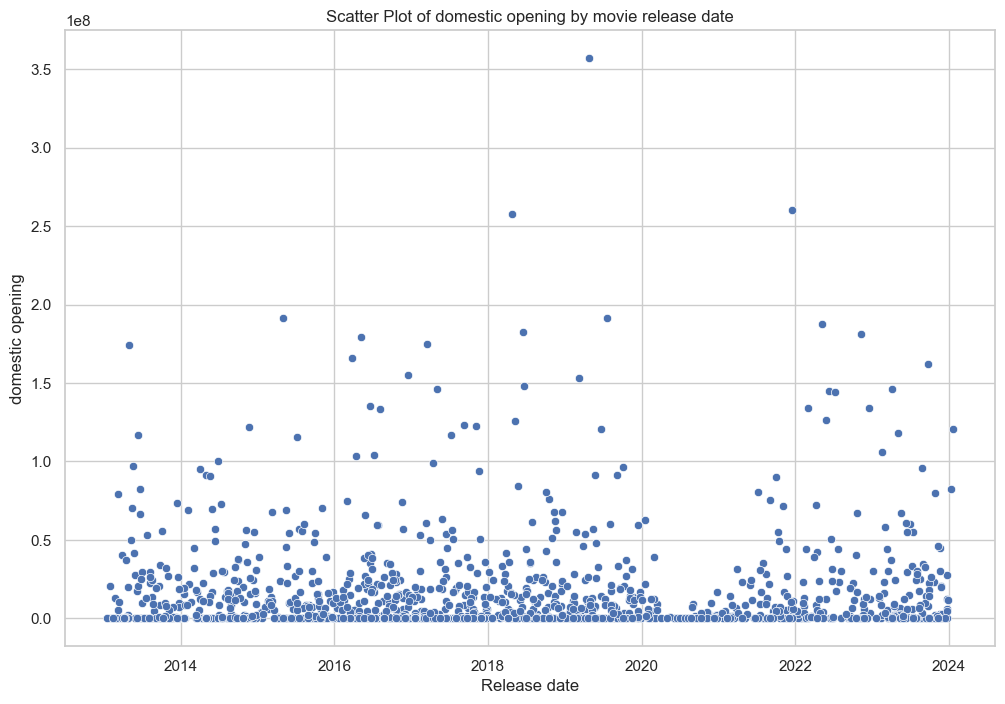

In [167]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='release_date', y='domestic_opening', data=final_df3)

# Set labels and title
plt.xlabel('Release date')
plt.ylabel('domestic opening')
plt.title('Scatter Plot of domestic opening by movie release date')

# Show the plot
plt.show()

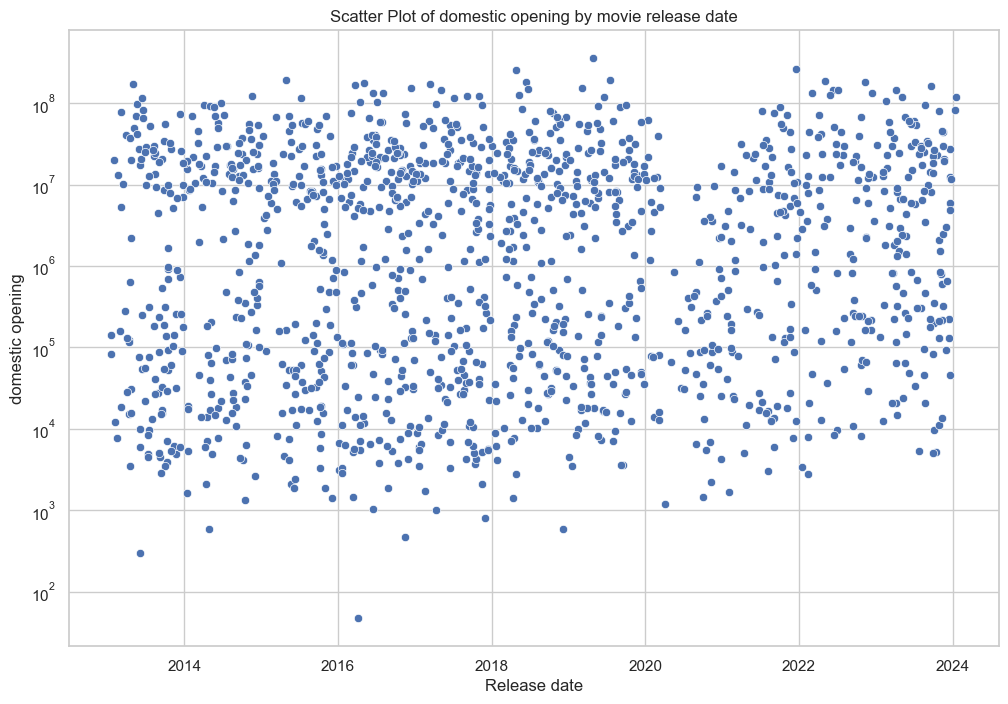

In [168]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='release_date', y='domestic_opening', data=final_df3)

plt.yscale('log')
# Set labels and title
plt.xlabel('Release date')
plt.ylabel('domestic opening')
plt.title('Scatter Plot of domestic opening by movie release date')

# Show the plot
plt.show()

In [169]:
final_df3['year'] = final_df3['release_date'].dt.year
final_df3['year_qtr'] = final_df3['release_date'].dt.year.astype(str) + 'Q' + final_df3['release_date'].dt.quarter.astype(str)
final_df3.sample()

/var/folders/bz/qyvd1hfs07v7gkh9fbvpy51m0000gn/T/ipykernel_72824/1725176518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df3['year'] = final_df3['release_date'].dt.year
/var/folders/bz/qyvd1hfs07v7gkh9fbvpy51m0000gn/T/ipykernel_72824/1725176518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df3['year_qtr'] = final_df3['release_date'].dt.year.astype(str) + 'Q' + final_df3['release_date'].dt.quarter.astype(str)


,post_id,post_title,post_url,post_score,num_comments,post_create_date,post_flair,movie_searched,Match,release_date,...,Actors,Awards,Rated,imdbRating,imdbVotes,Metascore,BoxOffice,Rating Category,year,year_qtr
738,kahve0,Nobody - Official Trailer,https://www.youtube.com/watch?v=wZti8QKBWPo,1888,406,2020-12-10 16:01:04,Trailers,Nobody,1,2021-03-26,...,"Bob Odenkirk, Aleksey Serebryakov, Connie Nielsen",5 wins & 18 nominations,R,7.4,"319,685",64.0,"$27,568,035",Adult,2021,2021Q1


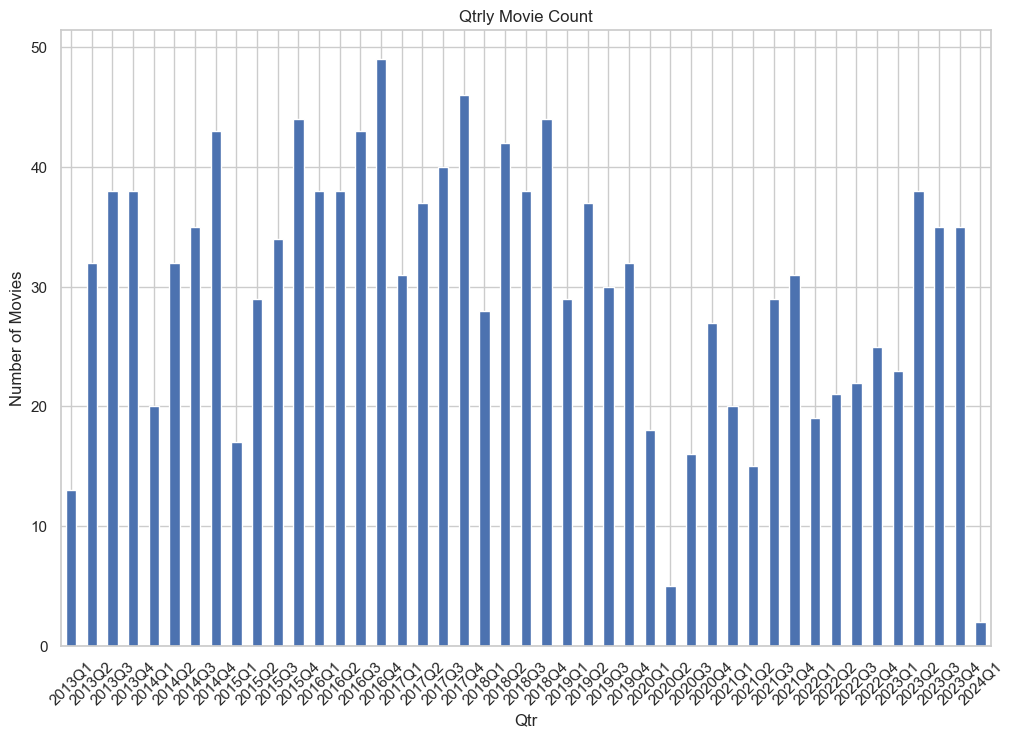

In [170]:
Qtrly_movie_count = final_df3['year_qtr'].value_counts().sort_index()

sns.set(style="whitegrid")
# Plotting
plt.figure(figsize=(12, 8))
Qtrly_movie_count.plot(kind='bar')
plt.xlabel('Qtr')
plt.ylabel('Number of Movies')
plt.title('Qtrly Movie Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# getting comments before release date

In [171]:
reddit_comments_w_release = reddit_comments.merge(final_df3[['post_id','post_create_date','movie_searched','release_date']], on='post_id', how='left')
reddit_comments_w_release.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451017 entries, 0 to 451016
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   body              451017 non-null  object        
 1   post_date         451017 non-null  datetime64[ns]
 2   upvotes           451017 non-null  int64         
 3   parent_id         328935 non-null  object        
 4   top_level_id      451017 non-null  object        
 5   post_title        451017 non-null  object        
 6   post_id           451017 non-null  object        
 7   post_create_date  268935 non-null  datetime64[ns]
 8   movie_searched    268935 non-null  object        
 9   release_date      268935 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(6)
memory usage: 34.4+ MB


In [172]:
reddit_comments['post_id'].nunique()

3166

In [173]:
final_df3['post_id'].nunique()

1358

In [174]:
reddit_comments_w_release['movie_searched'].nunique()

1256

In [175]:
reddit_comments_w_release.sample(10)

,body,post_date,upvotes,parent_id,top_level_id,post_title,post_id,post_create_date,movie_searched,release_date
257260,This is art coming full circle. Robin Hood ins...,2018-05-03 15:11:07,61,dydrea1,dydrea1,Robin Hood (2018 Movie) Teaser Trailer – Taron...,8gq9us,2018-05-03 13:14:51,Robin Hood,2018-11-21
245092,He also told Gambon to not bother reading the ...,2018-03-13 21:09:10,22,dvndxey,dvn1s8m,Fantastic Beasts: The Crimes of Grindelwald - ...,84593n,2018-03-13 16:01:10,Fantastic Beasts: The Crimes of Grindelwald,2018-11-16
121073,I'm sorry Robert Pattinson is the Heron? What?,2023-11-02 16:28:48,396,NaN,k7iy5uq,THE BOY AND THE HERON | Official English Trailer,17m6s2y,NaT,NaN,NaT
288776,"If you mean, ""Are we all going to get killed?...",2019-08-01 22:13:33,6,NaN,evquoj9,1917 - Official Trailer [HD],ckphl2,NaT,NaN,NaT
327844,Final shot should've been her getting undresse...,2019-07-16 21:34:26,1,NaN,ety4bb0,Itsy Bitsy Trailer #1 (2019) | Movieclips Indie,cdzvk8,NaT,NaN,NaT
305006,So dirty rotten scoundrels with women? gee how...,2019-02-12 16:43:31,-7,NaN,egbd3n2,THE Hustle (2019) | Official Trailer | Anne Ha...,aptr4v,2019-02-12 14:16:26,The Hustle,2019-05-10
171227,I was invited to see a prescreener of this mov...,2015-10-16 00:46:34,86,cw0w2dx,cw0w2dx,Ratchet & Clank Official Trailer,3ovtby,2015-10-15 17:47:28,Ratchet & Clank,2016-04-29
243061,[deleted],2018-07-21 20:51:42,31,e2snk7x,e2smz40,Aquaman Official Trailer,90rsv6,2018-07-21 19:24:14,Aquaman,2018-12-21
15858,Crap I forgot he was in that! The ending made ...,2013-07-24 21:27:19,22,cb9jj0m,cb9dkmo,47 Ronin - Official Trailer [HD] Keanu Reeves,1iyr45,2013-07-24 16:42:22,47 Ronin,2013-12-25
115904,Colin Firth in a family magic movie with mostl...,2018-09-17 15:54:21,5,NaN,e64yzp1,Mary Poppins Returns | Official Trailer #2,9gk0zv,2018-09-17 12:49:19,Mary Poppins Returns,2018-12-19


In [176]:
missing_values = reddit_comments_w_release.isnull().sum()
print(missing_values)

body                     0
post_date                0
upvotes                  0
parent_id           122082
top_level_id             0
post_title               0
post_id                  0
post_create_date    182082
movie_searched      182082
release_date        182082
dtype: int64


In [177]:
reddit_comments_w_release = reddit_comments_w_release.dropna(subset=['movie_searched'])
reddit_comments_w_release.isnull().sum()

body                    0
post_date               0
upvotes                 0
parent_id           68653
top_level_id            0
post_title              0
post_id                 0
post_create_date        0
movie_searched          0
release_date            0
dtype: int64

In [178]:
reddit_comments_w_release['date_diff'] = (reddit_comments_w_release['release_date'] - reddit_comments_w_release['post_date']).dt.days

reddit_comments_w_release[['release_date','post_date','date_diff']].head()


,release_date,post_date,date_diff
0,2013-12-25,2013-06-17 14:27:18,190
1,2013-12-25,2013-06-17 18:53:59,190
2,2013-12-25,2013-06-17 19:16:00,190
3,2013-12-25,2013-06-17 19:56:29,190
4,2013-12-25,2013-06-17 19:16:55,190


In [179]:
reddit_comments_w_release['date_diff'].describe([0.01,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.99])

count    268935.000000
mean        114.042233
std         215.451970
min       -3486.000000
1%         -405.860000
2.5%         -6.000000
5%           22.000000
10%          37.000000
25%          70.000000
50%         107.000000
75%         164.000000
90%         225.000000
99%         657.000000
max        1043.000000
Name: date_diff, dtype: float64

In [180]:
filtered_df = reddit_comments_w_release[reddit_comments_w_release['date_diff'] > 900]

# Select specific columns and drop duplicates
unique_rows = filtered_df[['post_title', 'movie_searched', 'post_create_date', 'release_date']].drop_duplicates()

# Display the unique rows
print(unique_rows)

                                  post_title     movie_searched  \
396168  Top Gun: Maverick - OFFICIAL TRAILER  Top Gun: Maverick   

          post_create_date release_date  
396168 2019-07-18 19:17:14   2022-05-27  


In [181]:
reddit_comments_before_release = reddit_comments_w_release[reddit_comments_w_release['date_diff'] > 0]
reddit_comments_before_release.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260781 entries, 0 to 451007
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   body              260781 non-null  object        
 1   post_date         260781 non-null  datetime64[ns]
 2   upvotes           260781 non-null  int64         
 3   parent_id         194354 non-null  object        
 4   top_level_id      260781 non-null  object        
 5   post_title        260781 non-null  object        
 6   post_id           260781 non-null  object        
 7   post_create_date  260781 non-null  datetime64[ns]
 8   movie_searched    260781 non-null  object        
 9   release_date      260781 non-null  datetime64[ns]
 10  date_diff         260781 non-null  int64         
dtypes: datetime64[ns](3), int64(2), object(6)
memory usage: 23.9+ MB


In [182]:
reddit_comments_before_release.to_csv('reddit_comments_before_release.csv',index=False)